### 기본 텍스트 분류
- 학습목표 : 영화 리뷰 텍스트를 긍정 또는 부정으로 분류하기

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.1.0


#### IMDB 데이터셋 다운로드
num_words = 10000는 훈련 데이터에서 가장 많이 등장하는 상위 10000개의 단어를 선택함.  
데이터 크기를 적당하게 유지하기 위함.

In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

#### 데이터 탐색
이 데이터셋의 샘플은 전처리된 정수 배열임. 정수 자체는 리뷰에 나오는 단어를 나타냄.  
라벨은 0(부정)과 1(긍정)이 있음.

In [3]:
print("훈련 샘플 : {}, 레이블 : {} ".format(len(train_data), len(train_labels)))

훈련 샘플 : 25000, 레이블 : 25000 


첫 번째 리뷰(데이터)를 확인 해보자.  
특정 단어들을 나타내는 정수들로 표현된걸 확인

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


영화 리뷰들은 개수 통일이 없음 >> 신경망의 입력은 길이가 같아야 하기 때문에 나중에 이 문제를 해결해야함.

In [5]:
len(train_data[0]) , len(train_data[1])

(218, 189)

#### 정수를 단어로 다시 변환하기
정수를 다시 텍스트로 변환하는 방법이 있다면 유용.  
정수와 문자열을 매핑한 딕셔너리를 개체에 질의하는 헬퍼 함수를 만들어보자.


In [6]:
word_index = imdb.get_word_index()

word_index = {k : (v+3) for k,v in word_index.items()}
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<UNUSED>'] = 3

reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

def decode_reivew(text):
    return ' '.join([reverse_word_index.get(i,'?') for i in text])

이제 decode_review를 통해 첫 번째 리뷰 텍스트를 출력해보자

In [7]:
decode_reivew(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

#### 데이터 준비
리뷰-정수 배열은 신경망에 주입하기 전에 텐서로 변환되어야 함.  
변환 방법에는 몇가지가 있음.  
- 원-핫 인코딩(one-hot encoding)은 정수 배열을 0과 1로 이루어진 벡터로 변환함.  
    정수를 인덱스로 이용해 크기가 10000인 배열 인덱스에 1을 입력하는 하고 나머지는 0을 입력하는 방식
- 정수 배열의 길이가 모두 같도록 패딩(padding)을 추가해 max_length * num_reviews 크기의 정수 텐서를 만듬. 이런 형태의 텐서를 다룰 수 있는 임베딩 층을 신경망의 첫 번째 층으로 사용할 수 있음

이 튜토리얼에서는 두 번째 방식을 사용함.  
영화 리뷰의길이가 같아야 하므로 pad_sequences 함수를 사용해 길이를 맞추겠음.

In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data, value = word_index["<PAD>"],
                                                       padding = 'post',
                                                       maxlen= 256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data, value = word_index["<PAD>"],
                                                       padding = 'post',
                                                       maxlen= 256)


In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

패딩된 첫 번째리뷰 내용을 확인해보자

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

#### 모델 구성
신경망은 층을 쌓어서 만드. 이 구조에선느 두가지를 결정해야 함.
- 모델에서 얼마나 많은 층을 사용할 것인가?
- 각 층에서 얼마나 많은 은닉 유닛(hidden unit)을 사용할 것인가?

이 예제의 입력 데이터는 단어 인덱스 배열입니다. 예측한 레이블은 0 또는 1입니다. 이 문제에 맞는 모델을 구성해 보겠습니다.

In [18]:
# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기임
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


층을 순서대로 쌓아 분류기를 만듬
1. Embedding 층. 이 층은 정수로 인코딩된 단어를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이 벡터는 모델이 훈련되면서 학습됨. 이 벡터는 출력 배열에 새로운 차원이 추가됨. 최종 차원은 (batch, sequence, embedding)이 됨
2. GlobalAveragePooling1D 층은 sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법임.
3. 이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층(Dense)을 거침
4. 마지막 층은 하나의 출력 노드(node)를 가진 완전 연결층임. sigmoid 활성화 함수를 사용하여 0과 1사이의 실수를 출력함. 이 값은 확률 또는 신뢰도를 나타냄

#### 은닉 유닛
위 모델에는 입력과 출력 사이에 두 개의 중간 또는 '은닉'층이 있음. 출력(유닛 또는 노드, 뉴런)의 개수는 층이 가진 표현 공간(representational space)의 차원이 됨. = 내부 표현을 학습할 때 허용되는 네트워크 자유도의 양임.

모델에 많은 은늑 유닛과 층이 있다면 네트워크는 더 복잡한 표현을 학습할 수 있음. 하지만 네트워크 계산 비용이 많이 들고 원치 않는 패턴을 학습할 수도 있음. 이런 표현은 데이터의 성능을 향상시키지만 테슽 데이터에서는 그렇지 못함. 이를 과대적합이라 함. 

#### 손실 함수와 옵티마이저
이진 분류의 확률을 출력 하므로 binary_crossentropy 손실 함수를 사용  
다른 선택 가능한 손실 함수 mean_squared_error가 있지만 binary_crossentropy가 확률을 다루는데 적합. 이 함수는 확률 분포 간의 거리를 측정함. 여기에서는 정답인 타깃 분포와 예측 분포 사이의 거리임


In [19]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

#### 검증 세트 만들기
모델을 훈련할 떄 모델이 만난 적 없는 데이터에서 정확도를 확인하는 것이 좋음.  
원본 훈련 데이터에서 10000개의 샘플을 떼어내어 검증 세트(validation set)를 만들겠음.  


In [24]:
x_val =  train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#### 모델 훈련 
이 모델을 512개의 샘플로 이루어진 미니배치(mini-batch)에서 40번의 에포크 동안 훈련함.  
x_train과 y_train 텐서에 있는 모든 샘플에 대해 40번 반복한다는 뜻. 

In [25]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 74us/sample - loss: 0.6922 - accuracy: 0.5329 - val_loss: 0.6909 - val_accuracy: 0.5439
Epoch 2/40
15000/15000 [==============================] - 1s 36us/sample - loss: 0.6877 - accuracy: 0.6685 - val_loss: 0.6843 - val_accuracy: 0.6905
Epoch 3/40
15000/15000 [==============================] - 1s 35us/sample - loss: 0.6766 - accuracy: 0.7397 - val_loss: 0.6699 - val_accuracy: 0.7269
Epoch 4/40
15000/15000 [==============================] - 1s 36us/sample - loss: 0.6557 - accuracy: 0.7586 - val_loss: 0.6456 - val_accuracy: 0.7490
Epoch 5/40
15000/15000 [==============================] - 1s 37us/sample - loss: 0.6232 - accuracy: 0.7821 - val_loss: 0.6099 - val_accuracy: 0.7737
Epoch 6/40
15000/15000 [==============================] - 1s 40us/sample - loss: 0.5784 - accuracy: 0.8005 - val_loss: 0.5649 - val_accuracy: 0.7961
Epoch 7/40
15000/15000 [==============================] 

#### 모델 평가
모델으 성능을 확인해 보자.  
두 개의 값이 반환됨. 손실(오차를 나타내는 숫자이므로 낮을수록 좋음)과 정확도


In [26]:
results =model.evaluate(test_data, test_labels , verbose=2)

print(results)

25000/25000 - 1s - loss: 0.3340 - accuracy: 0.8722
[0.33401488532543183, 0.87216]


#### 정확도와 손실 그래프 그리기
model.fit()은 History 객체를 반환함. 여기에는 훈련한느 동안 일어난 모든 정보가 담긴 딕셔너리가 들어있음.

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

네 개의 항목이 있음. 훈련과 검증 단계에서 모니터링하는 지표들임.  
훈련 손실과 검증 손실을 그래프로 그려 보고, 훈련 정확도와 검증 정확도도 그래프로 그려서 비교해 봄.

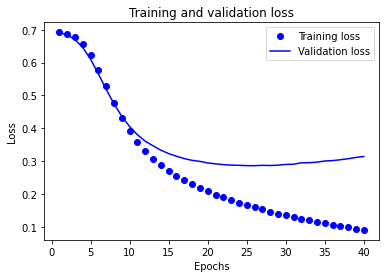

In [28]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss= history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다.
plt.plot(epochs, loss, "bo", label = 'Training loss')
# b는 "파란 실선"입니다.
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

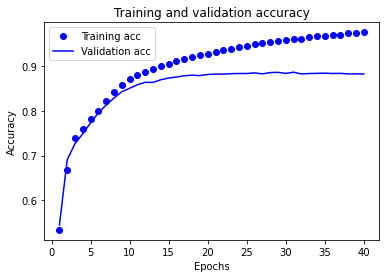

In [29]:
plt.clf() # 그림을 초기화

plt.plot(epochs, acc, 'bo', label= 'Training acc')
plt.plot(epochs, val_acc, 'b' , label= 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()

plt.show()

점선은 훈련 손실과 훈련 정확도  
실선은 검증 손실과 검증 정확도  

훈련 손실은 에포크마다 감소하고 훈련 정확도는 증가한다는 것을 주목.  
경사 하강법 최적화를 사용할 때 볼 수 있는 현상.  
매 반복마다 최적화 대상의 값을 최소화함.  

검증 손실은 약 20번째 에포크 이후가 최적점으로 추정. 이는 과대적합 때문. 

여기에서는 과대적합을 막기 위해 단순히 20번째 에포크 근처에서 훈련을 멈출 수 있음.
나중에 콜백(callback)을 사용하여 자동으로 이렇게 하는 방법을 배워 보겠음.